In [ ]:
# 首先实现朗之万动力学的score matching，然后加入sde schedule的score matching，然后实现ode形式的score matching

In [1]:
# 然后让我们用sde来给一个噪声路径

# dx = f(x)dt + g(x)dW, dW = torch.rand()


import lightning as pl
import torch
from MLPW.arc.utils.mlp import MLP
import math

class DSM_SDE(pl.LightningModule):
    def __init__(self):
        super(DSM_SDE, self).__init__()
        self.ms = MLP(3, 2)
    def f(self, x, t):
        # vp - sde, dx = sigma^t * dW, it is proven that closed from of gaussian p(x_t|x_0) = 0 + sigma^{2t-1}/2log(sigma) * eps
        pass
    def g(self, t):
        pass
    def sigma_v(self, t):
        # sigma can't be one
        sigma = 1.01
        return torch.sqrt((sigma**(2*t-1)/2/math.log(sigma))).to(t.device)
    def sde_colsed_form(self, x): # could we use not closed form, but step by step instead?(which will be really slow)
        eps = torch.randn_like(x)
        t = torch.rand((x.shape[0], 1))
        x = x.to(eps.device)
        t = t.to(eps.device)
        #print(x.device, t.device, eps.device)
        #dt = 1e-2
        #x = x + self.f(x, t) * dt + self.g(t) * eps
        xt = x + self.sigma_v(t)* eps
        return xt, eps, t
    def training_step(self, batch, batch_idx, sigma = 1):
        x = batch[0].to(self.device)
        xt, eps, t = self.sde_colsed_form(x)
        ss = self.ms(torch.cat((xt, t),dim=1))
        #print(ss.shape, eps.shape)
        # true score
        # score =  - ss / sigma
        loss = self.sigma_v(t)**2 * torch.nn.functional.mse_loss(self.sigma_v(t) *ss, eps)
        self.log("train_loss", loss)
        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.ms.parameters(), lr=1e-3)
        return optimizer

In [2]:
from MLPW.data.manifold import SwissRoll_DataModule
from lightning import Trainer
trian_loader = SwissRoll_DataModule().get_train_loader()
dsm_sde = DSM_SDE()
trainer = Trainer(max_epochs=50)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jiayi/.local/share/virtualenvs/MLPW-mOq2XAYX/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


score matching， simple variance

observe the influence of variance

we see that if the variance is too large, the distribution we match becomes vague. If the variance is too small, some points initialized at sparse points can't be moved back to distribution.

=> score matching 的 noise不能选太小，那样的model没有意义
=》 score matching的noise不能太大

In [ ]:
from MLPW.data.manifold import SwissRoll_DataModule
from lightning import Trainer
from MLPW.arc.scld import DSM
trian_loader = SwissRoll_DataModule().get_train_loader()
models = []
for sigma in [0.1, 0.5, 1, 5]:
    model = DSM(sigma=sigma)
    trainer = Trainer(max_epochs=50)
    trainer.fit(model, trian_loader)
    models.append(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jiayi/.local/share/virtualenvs/MLPW-mOq2XAYX/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type | Params | Mode 
--------------------------------------
0 | ms   | MLP  | 27.9 K | train
--------------------------------------
27.9 K    Trainable params
0         Non-trainable params
27.9 K    Total params
0.112     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/Users/jiayi/.local/share/virtualenvs/MLPW-mOq2XAYX/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve

Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 149.65it/s, v_num=80]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 148.34it/s, v_num=80]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode 
--------------------------------------
0 | ms   | MLP  | 27.9 K | train
--------------------------------------
27.9 K    Trainable params
0         Non-trainable params
27.9 K    Total params
0.112     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 169.55it/s, v_num=81]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 167.96it/s, v_num=81]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode 
--------------------------------------
0 | ms   | MLP  | 27.9 K | train
--------------------------------------
27.9 K    Trainable params
0         Non-trainable params
27.9 K    Total params
0.112     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 215.70it/s, v_num=82]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 213.20it/s, v_num=82]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode 
--------------------------------------
0 | ms   | MLP  | 27.9 K | train
--------------------------------------
27.9 K    Trainable params
0         Non-trainable params
27.9 K    Total params
0.112     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 186.33it/s, v_num=83]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 184.30it/s, v_num=83]


In [ ]:
T = 50
alpha = 1.0
eta = 0.5

x = []
for model in models:
    xt = (torch.rand(4000, 2)-0.5)*30
    for t in range(T):
        xt = xt + alpha * -model(xt) + eta*torch.randn_like(xt)
    x.append(xt)
    

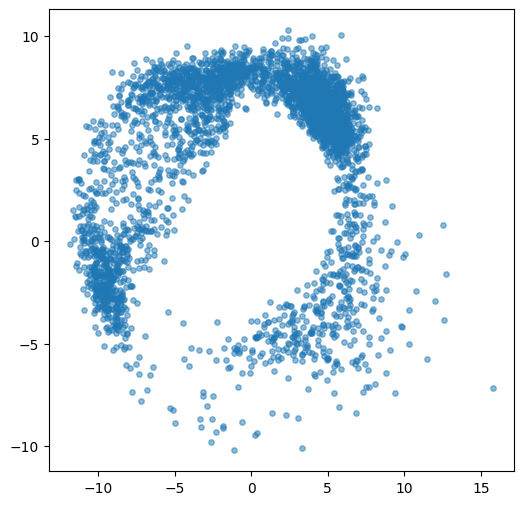

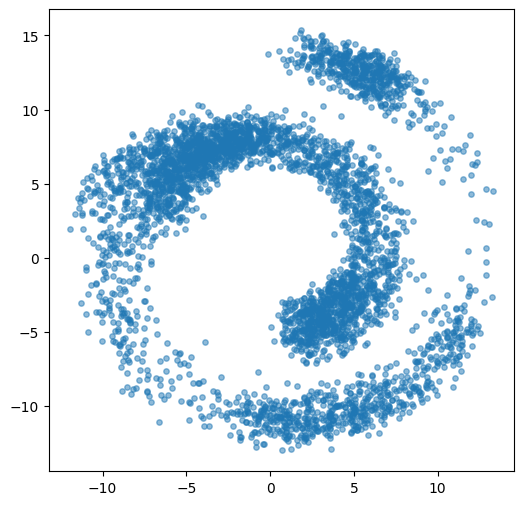

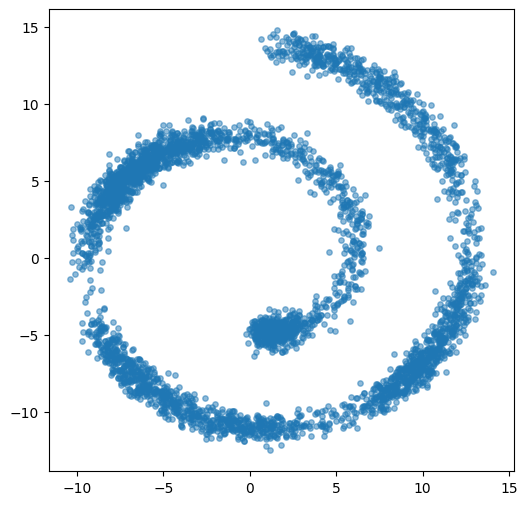

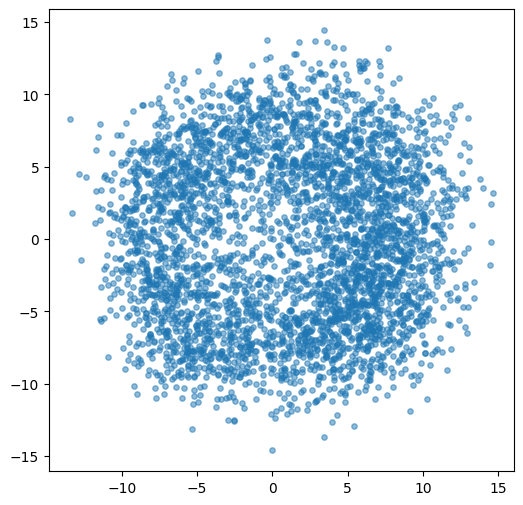

In [136]:
import matplotlib.pyplot as plt
for xt in x:
    xt = xt.detach().numpy()
    plt.figure(figsize=[6, 6])
    plt.scatter(xt[:, 0],xt[:, 1],s=15,alpha=0.5)
    plt.show()
    plt.close()

In [137]:
xt = (torch.rand(4000, 2)-0.5)*30
for model in models[::-1]:
    for t in range(int(T/50)):
        xt = xt + alpha * -model(xt) + eta*torch.randn_like(xt)

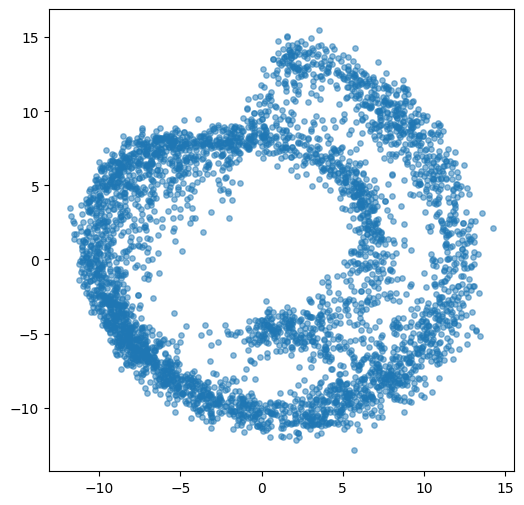

In [138]:
xt = xt.detach().numpy()
plt.figure(figsize=[6, 6])
plt.scatter(xt[:, 0],xt[:, 1],s=15,alpha=0.5)
plt.show()
plt.close()

In [139]:
model = DSM(sigma=2)
trainer = Trainer(max_epochs=50)
trainer.fit(model, trian_loader)
models.append(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jiayi/.local/share/virtualenvs/MLPW-mOq2XAYX/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type | Params | Mode 
--------------------------------------
0 | ms   | MLP  | 27.9 K | train
--------------------------------------
27.9 K    Trainable params
0         Non-trainable params
27.9 K    Total params
0.112     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/Users/jiayi/.local/share/virtualenvs/MLPW-mOq2XAYX/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve

Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 186.19it/s, v_num=84]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 184.32it/s, v_num=84]


In [150]:
xt = (torch.rand(4000, 2)-0.5)*30
for t in range(int(T/2)):
    xt = xt + alpha * -model(xt) + eta*torch.randn_like(xt)

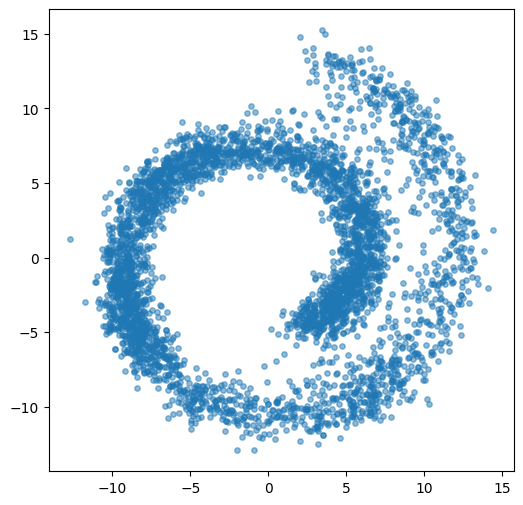

In [143]:
xt = xt.detach().numpy()
plt.figure(figsize=[6, 6])
plt.scatter(xt[:, 0],xt[:, 1],s=15,alpha=0.5)
plt.show()
plt.close()

In [151]:
for t in range(int(T/2)):
    xt = xt + alpha * -models[2](xt) + eta*torch.randn_like(xt)

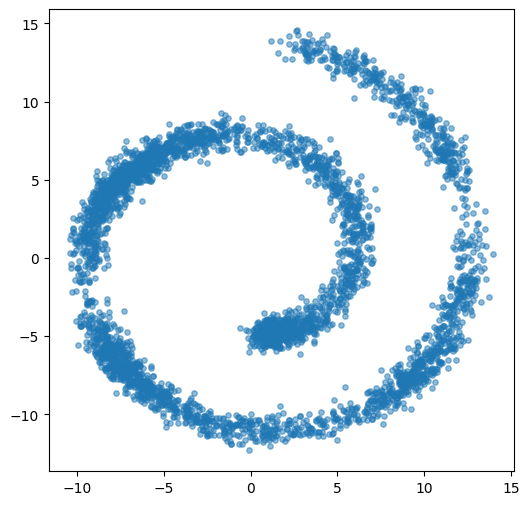

In [152]:
xt = xt.detach().numpy()
plt.figure(figsize=[6, 6])
plt.scatter(xt[:, 0],xt[:, 1],s=15,alpha=0.5)
plt.show()
plt.close()

In [98]:
# calculate variance of data
for batch in trian_loader:
    x = batch[0]
    break
var = torch.var(x, dim=0)
var

tensor([44.5109, 49.6503])

score matching with multi variance

1. continous time + simple MLP

In [3]:
import torch
import torch.nn as nn
import lightning as pl
import numpy as np

class TimeEmbedDSM(pl.LightningModule):
    def __init__(self, num_scales=10, sigma_min=0.001, sigma_max=10, hidden_dim=128):
        super().__init__()
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.num_scales = num_scales
        
        # Time embedding (for noise level conditioning)
        self.t_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Score network (now takes x + time embedding)
        self.ms = nn.Sequential(
            nn.Linear(2 + hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )
        
    def forward(self, x, sigma):
        # Convert sigma to log domain and normalize
        log_sigma = torch.log(sigma).reshape(-1, 1)
        t_embed = self.t_embed(log_sigma)  # (B, hidden_dim)
        
        # Concatenate x and time embedding
        h = torch.cat([x, t_embed], dim=-1)
        return self.ms(h)
    
    def training_step(self, batch, batch_idx):
        x = batch[0]
        
        # Sample random noise levels (log-uniform)
        log_sigma = torch.rand(x.shape[0], 1) * (
            np.log(self.sigma_max) - np.log(self.sigma_min)
        ) + np.log(self.sigma_min)
        sigma = torch.exp(log_sigma).to(x.device)
        
        eps = torch.randn_like(x)
        x_noisy = x + sigma * eps
        
        # Predict score (∇log p)
        score_pred = self(x_noisy, sigma)
        
        # DSM loss (equivalent to weighted MSE)
        loss = 0.5 * ((score_pred * sigma + eps) ** 2).mean()
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [4]:
from MLPW.data.manifold import SwissRoll_DataModule
from lightning import Trainer
# Training
trian_loader = SwissRoll_DataModule().get_train_loader()
model = TimeEmbedDSM()
trainer = Trainer(max_epochs=50)
trainer.fit(model, trian_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jiayi/.local/share/virtualenvs/MLPW-mOq2XAYX/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | t_embed | Sequential | 16.8 K | train
1 | ms      | Sequential | 33.5 K | train
-----------------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total 

Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 126.27it/s, v_num=109]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 124.70it/s, v_num=109]


In [94]:
@torch.no_grad()
def annealed_langevin_dynamics(model, 
                                num_samples=1000, 
                                num_steps_each=100, 
                                sigma_min=0.001, 
                                sigma_max=10.0, 
                                num_scales=10,
                                step_lr=0.1):
    """
    Annealed Langevin Dynamics sampling using a trained TimeEmbedDSM model.

    Parameters:
    - model: Trained TimeEmbedDSM
    - num_samples: Number of samples to generate
    - num_steps_each: Number of Langevin steps per noise level
    - sigma_min, sigma_max: Minimum/maximum noise levels
    - num_scales: Number of noise levels
    - step_lr: Langevin step size coefficient
    - device: 'cuda' or 'cpu'
    """
    model.eval()

    # Generate logarithmically spaced sigmas (descending for annealing)
    sigmas = torch.exp(
        torch.linspace(
            np.log(sigma_max), np.log(sigma_min), num_scales
        )
    )

    # Initialize random noise
    x = torch.randn(num_samples, 2)

    for sigma in sigmas:
        sigma_val = sigma.item()
        for _ in range(num_steps_each):
            # Compute score
            sigma_batch = sigma.expand(x.shape[0], 1)
            grad = model(x, sigma_batch)  # ∇log p(x)

            # Langevin step
            noise = torch.randn_like(x)
            step_size = step_lr * (sigma_val ** 2)
            x = x + step_size * grad + torch.sqrt(torch.tensor(2.0 * step_size)) * noise

    return x.detach().cpu()


3.descrite + simple MLP

In [3]:
import torch
import torch.nn as nn
import lightning as pl  # 或 import lightning.pytorch as pl
from MLPW.arc.utils.mlp import MLP
import numpy as np

class TimeEmbedDSM(pl.LightningModule):  # 明确继承 LightningModule
    def __init__(self, num_scales=10, sigma_min=0.01, sigma_max=10, hidden_dim=128):
        super().__init__()  # 必须调用父类初始化
        self.save_hyperparameters()  # 可选：保存超参数
        self.ms = MLP(3, 2)
        self.sigmas = torch.exp(
        torch.linspace(
            np.log(sigma_max), np.log(sigma_min), num_scales
        ))
    
    def forward(self, x):
        return self.ms(x)
    
    def training_step(self, batch, batch_idx):
        x = batch[0]
        t_index = torch.randint(0, len(self.sigmas), (x.shape[0], 1), device=x.device) 
        sigma = self.sigmas.to(x.device)[t_index]
        eps = torch.randn_like(x)
        x_noisy = x + sigma * eps
        score_pred = self(torch.cat((x_noisy, t_index.float()), dim=-1))
        loss = 0.5 * ((score_pred * sigma + eps) ** 2).mean()
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [4]:
from MLPW.data.manifold import SwissRoll_DataModule
from lightning import Trainer
# Training
trian_loader = SwissRoll_DataModule().get_train_loader()
model = TimeEmbedDSM()
trainer = Trainer(max_epochs=50)
trainer.fit(model, trian_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jiayi/.local/share/virtualenvs/MLPW-mOq2XAYX/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name | Type | Params | Mode 
--------------------------------------
0 | ms   | MLP  | 28.0 K | train
--------------------------------------
28.0 K    Trainable params
0         Non-trainable params
28.0 K    Total params
0.112     Total estimated model params size (MB)
7         Modules in train mode
0         Mod

Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 170.73it/s, v_num=112]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 169.02it/s, v_num=112]


In [5]:
@torch.no_grad()
def annealed_langevin_dynamics(model, 
                                num_samples=1000, 
                                num_steps_each=100, 
                                sigma_min=0.01, 
                                sigma_max=10.0, 
                                num_scales=10,
                                step_lr=0.1):
    model.eval()
    # Initialize random noise
    sigmas = torch.exp(
        torch.linspace(
            np.log(sigma_max), np.log(sigma_min), num_scales
        )
    )
    times = torch.linspace(
            0, 9, num_scales
        )
    print(times)
    x = (torch.rand(num_samples, 2) - 0.5) * 30

    for (sigma, time)  in zip(sigmas, times):
        sigma_val = sigma.item()
        for _ in range(num_steps_each):
            # Compute score
            t = time*torch.ones((x.shape[0], 1))
            sigma_batch = sigma.expand(x.shape[0], 1)
            grad = model(torch.cat((x, t), dim=-1))  # ∇log p(x)

            # Langevin step
            noise = torch.randn_like(x)
            step_size = step_lr * (sigma_val ** 2)
            x = x + step_size * grad + torch.sqrt(torch.tensor(2.0 * step_size)) * noise

    return x.detach().cpu()

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])


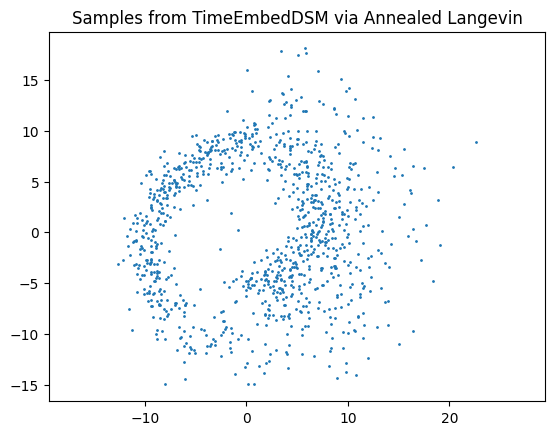

In [6]:
import matplotlib.pyplot as plt
samples = annealed_langevin_dynamics(model, num_samples=1000)
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.title("Samples from TimeEmbedDSM via Annealed Langevin")
plt.axis('equal')
plt.show()

discrete+ expressive

In [106]:
import torch
import torch.nn as nn
import lightning as pl  # 或 `import lightning.pytorch as pl`
from MLPW.arc.utils.mlp import MLP

class TimeEmbedDSM(pl.LightningModule):  # 明确继承 LightningModule
    def __init__(self, num_scales=10, sigma_min=0.01, sigma_max=10, hidden_dim=128):
        super().__init__()  # 必须调用父类初始化
        self.save_hyperparameters()  # 可选：保存超参数
        t_dim = 16
        x_dim = 2
        self.sigmas = torch.exp(
        torch.linspace(
            np.log(sigma_max), np.log(sigma_min), num_scales
        ))
        self.embedding = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, t_dim)
        )
        self.net = MLP(x_dim + t_dim, x_dim)

    def forward(self, x, t_index):
        # t_index: (B, 1)
        t_emb = self.embedding(t_index.float())  # [B, t_dim]
        x = torch.cat([x, t_emb], dim=-1)
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        x = batch[0]
        t_index = torch.randint(0, len(self.sigmas), (x.shape[0], 1), device=x.device) 
        sigma = self.sigmas.to(x.device)[t_index]
        eps = torch.randn_like(x)
        x_noisy = x + sigma * eps
        score_pred = self(x_noisy, t_index)
        loss = 0.5 * ((score_pred * sigma + eps) ** 2).mean()
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [107]:
from MLPW.data.manifold import SwissRoll_DataModule
from lightning import Trainer
# Training
trian_loader = SwissRoll_DataModule().get_train_loader()
model = TimeEmbedDSM()
trainer = Trainer(max_epochs=50)
trainer.fit(model, trian_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | embedding | Sequential | 2.3 K  | train
1 | net       | MLP        | 30.5 K | train
-------------------------------------------------
32.8 K    Trainable params
0         Non-trainable params
32.8 K    Total params
0.131     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
/Users/jiayi/.local/share/virtualenvs/MLPW-mOq2XAYX/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 145.90it/s, v_num=100]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 144.29it/s, v_num=100]


In [110]:
@torch.no_grad()
def annealed_langevin_dynamics(model, 
                                num_samples=4000, 
                                num_steps_each=100, 
                                sigma_min=0.01, 
                                sigma_max=10.0, 
                                num_scales=10,
                                step_lr=0.1):
    model.eval()

    # Initialize random noise
    sigmas = torch.exp(
        torch.linspace(
            np.log(sigma_max), np.log(sigma_min), num_scales
        )
    )
    times = torch.linspace(
            0, 9, num_scales
        )
    print(times)
    x = (torch.rand(num_samples, 2) - 0.5) * 30

    for (sigma, time)  in zip(sigmas, times):
        sigma_val = sigma.item()
        for _ in range(num_steps_each):
            # Compute score
            t = time*torch.ones((x.shape[0], 1))
            sigma_batch = sigma.expand(x.shape[0], 1)
            grad = model(x, t)  # ∇log p(x)

            # Langevin step
            noise = torch.randn_like(x)
            step_size = step_lr * (sigma_val ** 2)
            x = x + step_size * grad + torch.sqrt(torch.tensor(2.0 * step_size)) * noise

    return x.detach().cpu()

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])


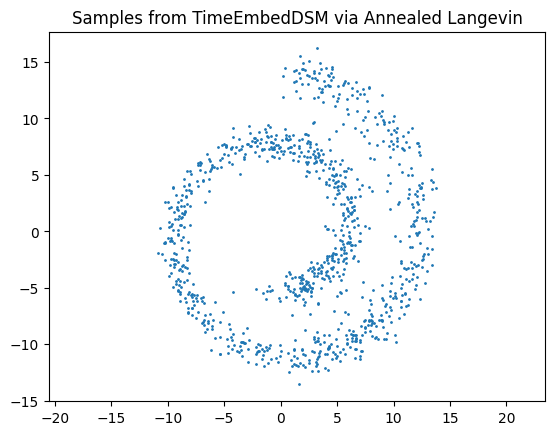

In [111]:
import matplotlib.pyplot as plt
samples = annealed_langevin_dynamics(model, num_samples=1000)
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.title("Samples from TimeEmbedDSM via Annealed Langevin")
plt.axis('equal')
plt.show()

In [ ]:
# 假设已有 MLP(in_dim, out_dim)
# 改为输入 x 和 t，拼接后送入 MLP

import torch
import torch.nn as nn
import lightning as pl
import numpy as np

class TimeEmbeddedMLP(nn.Module):
    def __init__(self, x_dim, t_dim, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, t_dim)
        )
        self.net = MLP(x_dim + t_dim, x_dim)

    def forward(self, x, t_index):
        # t_index: (B, 1)
        t_emb = self.embedding(t_index.float())  # [B, t_dim]
        x = torch.cat([x, t_emb], dim=-1)
        return self.net(x)

class IndexedDSM(pl.LightningModule):
    def __init__(self, noise_levels=None):
        super().__init__()
        if noise_levels is None:
            noise_levels = np.exp(np.linspace(np.log(0.1), np.log(10.0), 10))
        self.sigmas = torch.tensor(noise_levels, dtype=torch.float32)
        self.model = TimeEmbeddedMLP(x_dim=2, t_dim=16)

    def forward(self, x, t_index):
        return self.model(x, t_index)

    def training_step(self, batch, batch_idx):
        x = batch[0]
        B = x.shape[0]
        device = x.device

        t_index = torch.randint(0, len(self.sigmas), (B, 1), device=device) 
        sigma = self.sigmas.to(device)[t_index.squeeze()].view(-1, 1)

        eps = torch.randn_like(x)
        x_noised = x + sigma * eps
        score = self(x_noised, t_index)
        loss = 0.5 * torch.mean((score * sigma + eps) ** 2)

        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [50]:
# Training
trian_loader = SwissRoll_DataModule().get_train_loader()
model = IndexedDSM()
trainer = Trainer(max_epochs=50)
trainer.fit(model, trian_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | TimeEmbeddedMLP | 32.8 K | train
--------------------------------------------------
32.8 K    Trainable params
0         Non-trainable params
32.8 K    Total params
0.131     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 129.61it/s, v_num=74]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 128.29it/s, v_num=74]


In [51]:
@torch.no_grad()
def annealed_langevin_sampling(model, n_samples=4000, T=100, eta=0.1, device='cpu'):
    sigmas = model.sigmas.to(device)
    x = (torch.rand(n_samples, 2, device=device) - 0.5) * 30

    for t in reversed(range(len(sigmas))):
        sigma = sigmas[t].item()
        for _ in range(T):
            noise = torch.randn_like(x)
            t_index = torch.full((x.size(0), 1), t, dtype=torch.long, device=device)
            grad = model(x, t_index)
            x = x + eta * grad + torch.sqrt(torch.tensor(2 * eta)) * noise
    return x


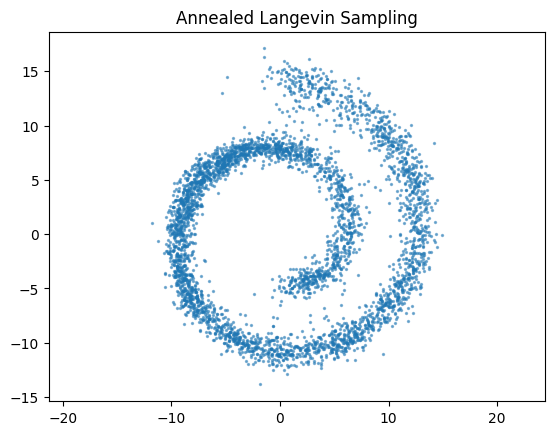

In [55]:
import matplotlib.pyplot as plt

samples = annealed_langevin_sampling(model, n_samples=4000, T=100, eta=0.01)
samples = samples.cpu().numpy()

plt.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.5)
plt.title("Annealed Langevin Sampling")
plt.axis('equal')
plt.show()